# 2次元Ising模型とくりこみ群変換
## Markov Chain Monte Carlo
2次元Isingハミルトニアン
$$
    H(\lbrace\sigma_i\rbrace) = -J\sum_{\left\langle i,j \right\rangle}\sigma_i\sigma_j
$$
に対するカノニカル分布
$$
    p(\lbrace\sigma_i\rbrace) = \frac{\exp\left(-\beta H(\lbrace\sigma_i\rbrace)\right)}{\sum_{\lbrace\sigma_i\rbrace} \exp\left(-\beta H(\lbrace\sigma_i\rbrace)\right)}
$$
に従うスピン配置$\lbrace\sigma_i\rbrace$を確率的に発生させる。

(Swendsen-Wang algorhism: Robert H. Swendsen and Jian-Sheng Wang, Phys. Rev. Lett. **58**, 86 (1987))

https://qiita.com/github-nakasho/items/68acc4e6e455eb1d607a

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:
# parameters
np.random.seed(0)

J = 1.0
beta_C = 1 / 2 / J * np.log(1 + np.sqrt(2))
beta = 0.8 * beta_C

L = 81
Nx = L
Ny = L
iteration = 1000
space = iteration // 10

block_size = 3;

In [3]:
#initial spin configuration
S_conf = (np.random.rand(Nx,Ny) > 0.5)
S_conf = S_conf.astype(np.int)
S_conf = 1 - 2 * S_conf

In [4]:
cluster = np.zeros(Nx * Ny, dtype=np.int)

In [5]:
def cluster_rank(cluster,ix,iy):
    rank = ix * Ny + iy

    while rank != cluster[rank]:
        rank = cluster[rank]
    return rank

In [6]:
def bond_connect(S_conf,cluster,ix1,iy1,ix2,iy2,p):
    ix2 = ix2 % Nx
    iy2 = iy2 % Ny
    
    if S_conf[ix1,iy1] * S_conf[ix2,iy2] < 0:
        return
    
    if np.random.rand() < p:
        rank1 = cluster_rank(cluster,ix1,iy1)
        rank2 = cluster_rank(cluster,ix2,iy2)
        if rank1 < rank2:
            cluster[rank2] = rank1
        else:
            cluster[rank1] = rank2



In [7]:
def spin_plot(S_conf,l):
    fig = plt.figure(figsize=(8,6))
    plt.imshow(S_conf,vmin=-1,vmax=1)
    plt.title("iter = " + str(l+1))
    plt.axis("off")
    plt.show()

In [8]:
def SW_flip(S_conf):
    for rank in range(Nx * Ny):
        cluster[rank] = rank
    p = 1.0 - np.exp(-2.0 * J * beta)
    cluster_flip = (np.random.rand(Nx * Ny) < 0.5) * (-2) + 1

    for ix in range(Nx):
        for iy in range(Ny):
            bond_connect(S_conf,cluster,ix,iy,ix+1,iy,p)
            bond_connect(S_conf,cluster,ix,iy,ix,iy+1,p)
    for ix in range(Nx):
        for iy in range(Ny):
            myrank = cluster_rank(cluster,ix,iy)
            S_conf[ix,iy] *= cluster_flip[myrank]


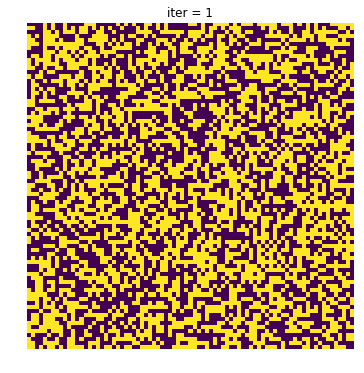

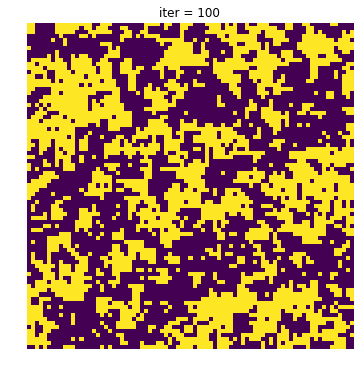

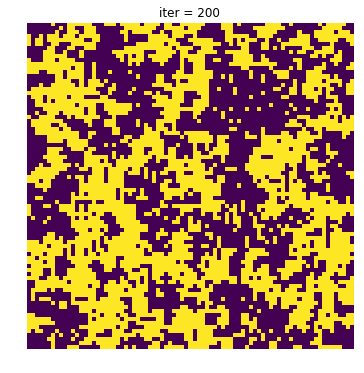

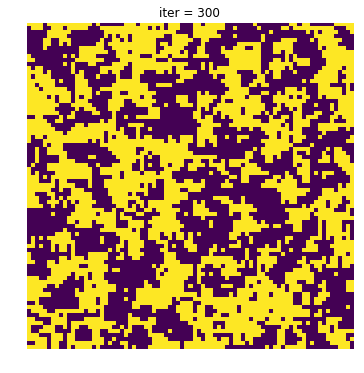

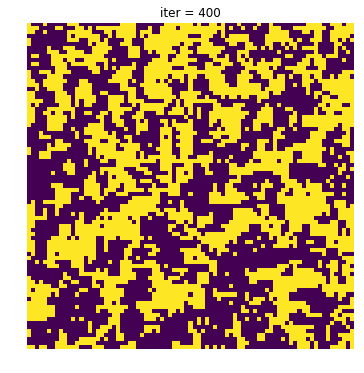

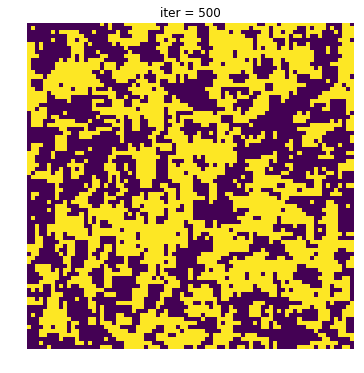

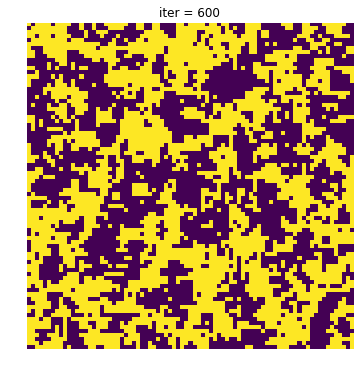

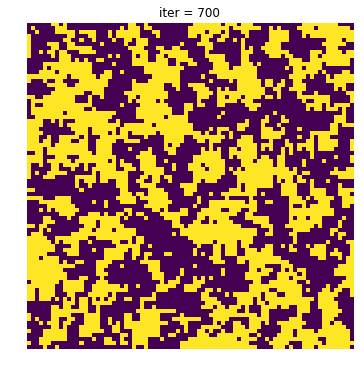

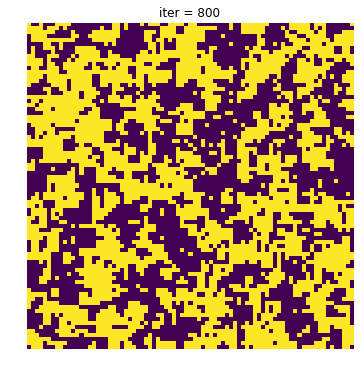

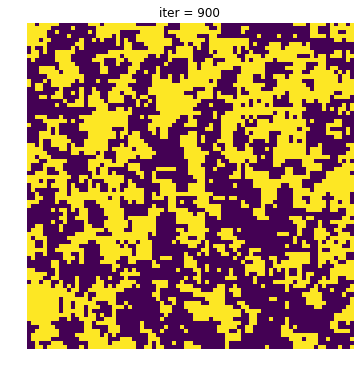

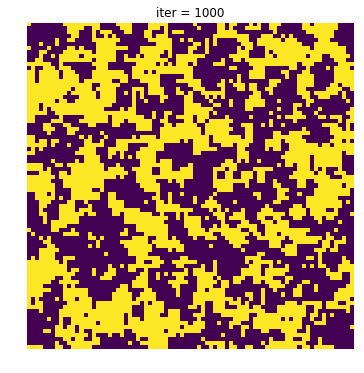

In [9]:
spin_plot(S_conf,0)
for l in range(iteration):    
    SW_flip(S_conf)
    if (l+1)%space == 0:
        spin_plot(S_conf,l)

## ブロックスピン変換(実空間のくりこみ群変換)
以下のようなブロックスピン変換を定義する($3\times 3$のブロックで多数決を取る)
<img src="./figure/RGtr.png" width="256px">
これは細かいスピンの構造を粗視化して、より自由度の小さい有効模型に変換する。このような粗視化の手続きを**くりこみ群変換**と呼ぶ。

Ising模型をブロックスピン変換(実空間くりこみ群変換)するとくりこまれたパラメータのIsing模型となる。
この変換による相図上における模型の振る舞いの変化(**くりこみ群のフロー**)によって、その相の巨視的な特性が明らかになる。

例えば、2次元のIsing模型の場合、$\beta > \beta_C$(低温)でくりこみ群変換を数回行うと、粗視化によってminor spinは潰れていき、やがてスピンが完全に揃った状態となる。
これは$\beta\to\infty$ (or $J\to\infty$)の極限に相当し、くりこみ群変換によって強磁性相としての特性がより明確になる事がわかる。
(例えば$\beta = 1.2\beta_C$)

一方で$\beta < \beta_C$(高温)でくりこみ群変換を行うと逆にスピンの相関が切れてばらばらになっていく。これは常磁性相($\beta\to 0$ or $J\to 0$)の性質を強めている。
(例えば$\beta = 0.8\beta_C$)

転移点$\beta = \beta_C$においては、くりこみ群変換を行っても巨視的な変化は殆ど現れない(わかりにくいかもしれないが、様々な大きさのドメインが現れていて(つまり、相関長が定義できない)、くりこみ群変換でもなかなか消えない)。このような相図上の点を**固定点**と呼ぶ。
2次元Ising模型では他に$\beta\to 0,\infty$が固定点であるが、これらと$\beta = \beta_C$は固定点としての性質が全く異なる。$\beta\to 0,\infty$では温度が多少ずれた際にくりこみ群変換を行うとその固定点に向かうが、相転移点$\beta = \beta_C$では少しでも温度がずれるとくりこみ群変換で$\beta = \beta_C$ではなく$\beta\to 0,\infty$に向かう。$\beta = \beta_C$は不安定な固定点であり、きちんとした解析が難しいのだが(Monte Carloの結果もかなり不安定であることがわかると思う)、くりこみ群の手法によって臨界現象について厳密かつ強力な主張ができる(参考文献)。

## 参考文献
- Hidetoshi Nishimori and Gerardo Ortiz, Elements of Phase Transitions and Critical Phenomena, Oxford University Press (2010)
- 高橋 和孝, 西森 秀稔, 相転移・臨界現象とくりこみ群, 丸善出版 (2017)


In [10]:
def block_spin_tr(S_conf,block_size=3):
    L_tr = (np.array(S_conf.shape)//block_size)[0]
    S_conf_tr = np.zeros((L_tr,L_tr))
    for ix in range(L_tr):
        for iy in range(L_tr):
            block_sum = np.sum(S_conf[ix*3:ix*3+3,iy*3:iy*3+3])
            if block_sum > 0:
                S_conf_tr[ix,iy] = +1
            elif block_sum < 0:
                S_conf_tr[ix,iy] = -1
            elif block_sum == 0:
                S_conf_tr[ix,iy] = 1 - 2 * np.random.randint(0,2)
    return S_conf_tr
                
    
    

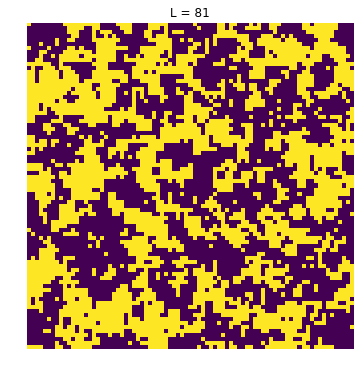

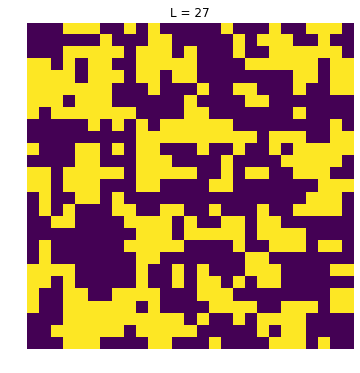

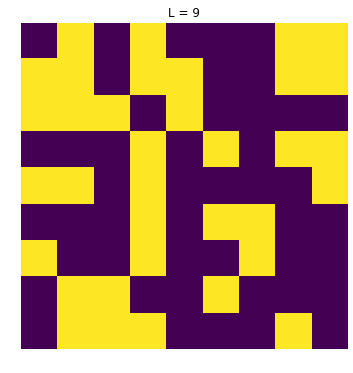

In [11]:
S_conf_tr = S_conf.copy()
fig = plt.figure(figsize=(8,6))
plt.imshow(S_conf_tr,vmin=-1,vmax=1)
plt.title("L = " + str((np.array(S_conf_tr.shape))[0]))
plt.axis("off")
plt.show()
for l in range(2):
    S_conf_tr = block_spin_tr(S_conf_tr,block_size=3)
    fig = plt.figure(figsize=(8,6))
    plt.imshow(S_conf_tr,vmin=-1,vmax=1)
    plt.title("L = " + str((np.array(S_conf_tr.shape))[0]))
    plt.axis("off")
    plt.show()